## NLP Analysis of Company Survey Response Data

This notebook will show the class created in order to take in the raw survey response data, prepare it for natural language processing, and then perform multiple different analyses. The code is robust in that it is able to evaluate each analysis by the dimensions that were part of the survey response (age, tenure, job function, gender, etc.). This notebook is intended to show my python capabilites and uncovering insights in one of the many different forms that data comes in. 

In [6]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding

import matplotlib.pyplot as plt
%matplotlib inline

## Explanation of the Class & Methods used 

The following code creates a class, Response and the methods from it. <br>
The filter_dims parameter will take in a dictionary of the different dimensional columns that each survery response contained. These were dimensions such as which country was the employee based out of, their gender, tenure, age and function. <br>
1. **return_data** <br>
This method would read in the csv of the response data and then create a dataframe based upon the dimensions seend in the pandas dataframe [[ ]] . 
2. **prepare_doc** <br>
This method asks you which column do you want to analyze, either the question regarding the positive or negative aspects of the company. Once responding it will load the english language model from spaCy. <br>
The next portion of the script is preparing the text that is currently in thousands of different rows in a pandas dataframe into a single concatenaded string. We will then pass this string through the spaCy NLP function so it will be lemmatized and tokenized for further analysis. 
3. **word_count** <br>
The word count method will take in any combination of parameters from the filterable dimensions. It will also take in to see the parameter **n** which will allow you to see the ngram words. So if **n** = 1 then it will look for the most common word, if it is 2 then it will look for the most common two words mentioned. You can also choose a plot type, our client wanted to see these results in the form of a word cloud or a bar chart. For these charts I leveraged the Matplotlib library. 
4. **phrase_count** <br>
Similar to the word count but this method will look for a certain pattern in the text. So we wanted to see which types of responses were given to the company that had a noun follow an adjective like 'good teamwork' or 'strong leadership'. You can see in the script that the pattern = [{'POS':'ADJ'}, {'POS':'NOUN'}] would allow you to analyze by this specific form of the english language. 
5. **proximity_freq_count** <br>
For this method, it will take in a word that you are interested to see how people responded to. If you for instance wanted to see what was being said about the company's leadership you would insert that as a parameter, as well as how many tokens away from that word you want to analyze and then run it. It will return back to you the most commonly used words that were surrounding the word leadership in your data. 

In [21]:
class Response:
    def __init__(self, csv, filter_dims: dict = None):
        self.csv = csv
        
    def return_data(self):
        df = pd.read_csv(self.csv)
        df = df[['What do you think the strengths are? (up to 5 attributes in English)', 
                'What do you think the improvement areas are? (up to 5 attributes in English)',
                 'Please select your Country.', 'What is your gender identity?', 'Please select your tenure ',
                'Select your age category', 'Please select your Function / SBU.' ]]
        df.columns = ['Positive', 'Negative', 'Country', 'Gender', 'Tenure', 'Age', 'Function' ]
        
        return df
    
    def prepare_doc(self, df, column):
        # logic for positive or negative column analyzed 
        if column == 'Positive' or column == 'positive':
            df = df[['Positive']]
            df.columns = ['Response']
            
        elif column == 'Negative' or column == 'negative':
            df = df[['Negative']]
            df.columns = ['Response']
        else:
            raise ValueError('Error. Did not enter Positive or Negative into column argument.')
    
        # load english model to tokenize text
        nlp = spacy.load('en_core_web_sm')
            
        # join text into single string
        all_text = df.Response.str.cat(sep=' ')
        
        # create a spaCy document with the text 
        doc = nlp(all_text, disable = ['ner'])

    def word_count(self, df, column, country: list=None, gender: list=None, tenure: list=None, 
                   age: list=None, function: list=None, n=None, plot_type=None):
        print('Response Type: ' + column)
        
        d = {"Country": country, "Gender": gender, "Tenure": tenure, "Age": age, "Function": function}
        
        
        import functools
        
        cond = [df[k].apply(lambda k: k in v if v != [''] else True) for k, v in d.items()]
        cond_total = functools.reduce(lambda x, y: x & y, cond)
        df = df[cond_total]
        
        # logic for positive or negative column analyzed 
        if column == 'Positive' or column == 'positive':
            df = df[['Positive']]
            df.columns = ['Response']
            
        elif column == 'Negative' or column == 'negative':
            df = df[['Negative']]
            df.columns = ['Response']
        else:
            raise ValueError('Error. Did not enter Positive or Negative into column argument.')
        
        # load english model to tokenize text
        nlp = spacy.load('en_core_web_sm')
            
        # join text into single string
        all_text = df.Response.str.cat(sep=' ')
        
        # lowercase it
        all_text = all_text.lower()
        
        # create a spaCy document with the text 
        doc = nlp(all_text, disable = ['ner'])
        
        # word count without stop words or punctuation 
        from collections import Counter 
        import textacy
        
        if n == 1 or n == None:
            words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
            word_freq = Counter(words)
            most_common_list = word_freq.most_common(20)
        else:
            ngrams = list(textacy.extract.ngrams(doc, n))
            ngram_words = [token.lemma_ for token in ngrams]
            ngram_word_freq = Counter(ngram_words)
            most_common_list = ngram_word_freq.most_common(20)
        
    
        if plot_type == 'WC' or plot_type == 'wc':
            # word cloud 
            from os import path
            from PIL import Image
            from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
            import matplotlib.pyplot as plt
            %matplotlib inline

            words_list = [x[0] for x in most_common_list]
            words_string = ' '.join(words_list)
            
            # Create and generate a word cloud image:
            wordcloud = WordCloud(max_font_size=100, width=700, height=500, background_color='white').generate(words_string)

            # Display the generated image:
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            return most_common_list, plt.show()
            
        elif plot_type == 'Bar' or plot_type == 'bar': 
            
            # prepare data for a bar chart 
            word_count_df = pd.DataFrame(most_common_list)
            word_count_df.columns = ['word', 'count']
            word_count_df.drop(word_count_df.loc[word_count_df['word']==' '].index, inplace=True)
            word_count_df.drop(word_count_df.loc[word_count_df['word']=='1'].index, inplace=True)
            word_count_df.drop(word_count_df.loc[word_count_df['word']=='2'].index, inplace=True)
            word_count_df
            
            return most_common_list, word_count_df.plot.bar(y='count', x='word')
        
        else: 
            raise ValueError('Error. Did not enter WC or Bar into plot_type argument.')
        
    
    def phrase_count(self, df, column):
        # prepare df
        df = pd.read_csv(df)
        
        print('Response Type: ' + column)
        
        # logic for positive or negative column analyzed 
        if column == 'Positive' or column == 'positive':
            df = df[['Positive']]
            df.columns = ['Response']
            
        elif column == 'Negative' or column == 'negative':
            df = df[['Negative']]
            df.columns = ['Response']
        else:
            raise ValueError('Error. Did not enter Positive or Negative into column argument.')
    
        # load english model to tokenize text
        nlp = spacy.load('en_core_web_sm')
            
        # join text into single string
        all_text = df.Response.str.cat(sep=' ')
        
        # create a spaCy document with the text 
        doc = nlp(all_text, disable = ['ner'])
        
        # pattern matching 
        from spacy.matcher import Matcher
        from collections import Counter

        matcher = Matcher(nlp.vocab)
        pattern = [{'POS':'ADJ'}, {'POS':'NOUN'}]
        matcher.add('ADJ_PHRASE', [pattern])

        matches = matcher(doc, as_spans=True)
        phrases = []
        
        for span in matches:
            phrases.append(span.text.lower())
            phrase_freq = Counter(phrases)

        return phrase_freq.most_common(30)
    
    def proximity_freq_count(self, df, column, word, token_num):
        print('Response Type: ' + column)
        print('Searched Word: ' + word)
        print('Number of Tokens away from searched word in both directions: ' + str(token_num))
        
        # logic for positive or negative column analyzed 
        if column == 'Positive' or column == 'positive':
            df = df[['Positive']]
            df.columns = ['Response']
            
        elif column == 'Negative' or column == 'negative':
            df = df[['Negative']]
            df.columns = ['Response']
        else:
            raise ValueError('Error. Did not enter Positive or Negative into column argument.')
    
        # load english model to tokenize text
        nlp = spacy.load('en_core_web_sm')
            
        # join text into single string
        all_text = df.Response.str.cat(sep=' ')
        
        # create a spaCy document with the text 
        doc = nlp(all_text, disable = ['ner'])
        
        from spacy.matcher import PhraseMatcher
        from collections import Counter
        
        word_colloc = []
        matcher = PhraseMatcher(nlp.vocab, attr = 'LOWER') 
        # The attr above ensures all instances are converted to lower-case so the search is case-insensitive
        pattern = [nlp.make_doc(word)]
        matcher.add(word, pattern) 
        matches = matcher(doc)
        for match_id, start, end in matches:
            span = doc[start-token_num : end+token_num]   
            word_colloc.extend([token.lemma_.lower() for token in span if not token.is_stop and not token.is_punct]) 
        return Counter(word_colloc).most_common(20)

In [22]:
auto_class = Response('RawData.csv')

In [24]:
df = auto_class.return_data()

## Example Data

In [26]:
df[:5]

,Positive,Negative,Country,Gender,Tenure,Age,Function
0,Optimistic future,"Faster decision making, investment in the futu...",USA,Female,1-5 years,35-50,DigITal
1,"Faster response to changes, highly dynamic,","Define clear long term goal, improve existing ...",Germany,Male,1-5 years,35-50,Customer Group Europe
2,NaN,NaN,India,Male,1-5 years,18-34,Automotive Services
3,NaN,NaN,India,Male,1-5 years,35-50,Telematics
4,Strong base of talented people,"Less focus on processes and tools, and way mor...",Israel,Male,1-5 years,above 50,Advanced Driver Assistance Systems


    def word_count(self, df, column, country: list=None, gender: list=None, tenure: list=None, 
                   age: list=None, function: list=None, n=None, plot_type=None):

### Example 1

In this example we will insert the dataframe into our class method. We are going to evaluate by the Positive response and see which was the most common word used and to show it in a word cloud. 

Response Type: Positive


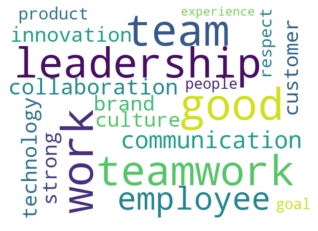

([(' ', 154),
  ('work', 136),
  ('team', 135),
  ('good', 103),
  ('leadership', 75),
  ('teamwork', 61),
  ('employee', 54),
  ('communication', 52),
  ('collaboration', 46),
  ('innovation', 44),
  ('brand', 43),
  ('technology', 42),
  ('customer', 41),
  ('culture', 41),
  ('strong', 39),
  ('product', 38),
  ('respect', 35),
  ('people', 35),
  ('goal', 35),
  ('experience', 33)],
 None)

In [31]:
auto_class.word_count(df, 'Positive', [''], [''], [''], [''], [''], 1, 'WC')

### Example 2

The following word_count method will return a Word Cloud denoted from the final parameter 'WC' of the bigram (2 words) most mentioned from the Female population in India. 

Response Type: Positive


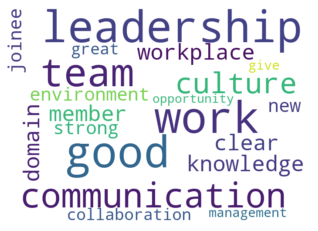

([('team work', 20),
  ('work culture', 8),
  ('good leadership', 7),
  ('leadership team', 6),
  ('clear communication', 4),
  ('domain knowledge', 4),
  ('workplace culture', 4),
  ('good work', 4),
  ('good communication', 3),
  ('team member', 3),
  ('work environment', 3),
  ('work leadership', 2),
  ('leadership 2', 2),
  ('strong leadership', 2),
  ('communication good', 2),
  ('new joinee', 2),
  ('collaboration 1', 2),
  ('great team', 2),
  ('good management', 2),
  ('give opportunity', 2)],
 None)

In [27]:
auto_class.word_count(df, 'Positive', ['India'], ['Female'], [''], [''], [''], 2, 'WC')

We see that the term 'team work' was mentioned 20 times in a positive manner. One can take away that the Females in India thought there was good team work in their organization.  

### Example 3

We will now look at the Negative response which asked what can be done to improve the company? We will look at the two words most commonly used.  

Response Type: Negative


([('life balance', 57),
  ('automotive division', 44),
  ('team work', 42),
  ('team member', 40),
  ('long term', 36),
  ('new technology', 35),
  ('cross functional', 34),
  ('clear communication', 30),
  ('work life', 26),
  ('project management', 25),
  ('lesson learn', 23),
  ('new business', 23),
  ('organization structure', 22),
  ('team building', 21),
  ('knowledge sharing', 20),
  ('organizational structure', 19),
  ('work culture', 19),
  ('car audio', 19),
  ('harman automotive', 19),
  ('functional team', 19)],
 <AxesSubplot:xlabel='word'>)

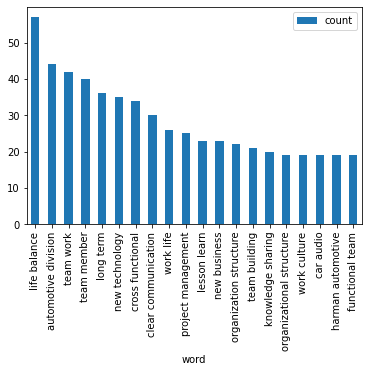

In [32]:
auto_class.word_count(df, 'Negative', [''], [''], [''], [''], [''], 2, 'Bar')

Another way of representing the words is through a bar chart. We can see that life balance was the word used most often in the Negative response, or what can be improved at this company. 

### Example 4

We just learned that 'life balance' was the most common bigram in the survey response. What if we wanted to see what other words were being mentioned close to it in responses. We can use the proximity_freq_count method that will seek the most commonly used words within a certain token count from the word searched. 

In [37]:
auto_class.proximity_freq_count(df, 'negative', 'life', 5) 

Response Type: negative
Searched Word: life
Number of Tokens away from searched word in both directions: 5


[('life', 70),
 ('work', 69),
 ('balance', 64),
 (' ', 17),
 ('employee', 8),
 ('improve', 7),
 ('1', 6),
 ('need', 6),
 ('3', 5),
 ('team', 5),
 ('time', 4),
 ('2', 4),
 ('management', 4),
 ('communication', 4),
 ('transparency', 3),
 ('improvement', 3),
 ('project', 3),
 ('well', 3),
 ('expectation', 3),
 ('process', 3)]